## Approach


* Missing value analysis and treatment.
* Outlier analysis and treatment.
* Basic EDA to analyze and visualize the distribution of data
* Scale the data, if required.
* Check the Hopkin's Statistic to see if the data has a tendency to cluster,
* Use Elbow curve and Silhouette score to check optimal cluster count.
* Deploy KMeans clustering algorithm for the appropriate cluster values and analyze the clusters.
* Deploy Hierarchical clustering algoritm and analyze the clsuters formed on appropriate cluster counts.
* Identify which clustering method gives us a better cluster formation and finalize the method.
* Finalize the cluster that needs attention from the business basis various socio-economic factors like high child mortality,    less income and less gdpp.
* Analyze the final cluster and check its statistics
* Filter 10 countries from the foinal cluster in direst need of assistance based on gdpp, income and child mortality (in order).
* Present the final list of countries to the business.

In [1]:
#supressing warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

## Reading the data and understanding the dataset

In [3]:
#importing the dataset
df = pd.read_csv("Country-data.csv")

In [4]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
df.shape

(167, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [7]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


## Missing value check

In [8]:
#Checking null values
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

<p style= "background:skyblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> There is <b> no missing data in the dataset.</b>

## Data Transofrmation

<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> We see that there are a few columns that are expressed in %ages of the total GDP of the country - here, if we do not transform the values the end picture might not be a true reflection of what the ground reality is. 
For example, Tunisia spends 6.21% of its GDPP on health whereas, UAE spends only 3.66% of its GDPP on health. Just looking at the %age would make the model believe that Tunisia fares better than UAE in health!
However, when we convert the %age into the absolute value we get the following:
  
    >> Tunisia - 6.21% of 4140  = 257.094
    >> UAE     - 3.66% of 35000 = 1281
<p style= "background:lightblue">  <font color ="darkblue"> Clearly, UAE fares better.
Hence, in my opinion, we should convert these %ages to absolute values.
    

In [9]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [10]:
#Converting %ages to absolute values
df["exports"] = df["exports"]*df["gdpp"]/100
df["imports"] = df["imports"]*df["gdpp"]/100
df["health"] = df["health"]*df["gdpp"]/100

df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


## Outlier Analysis

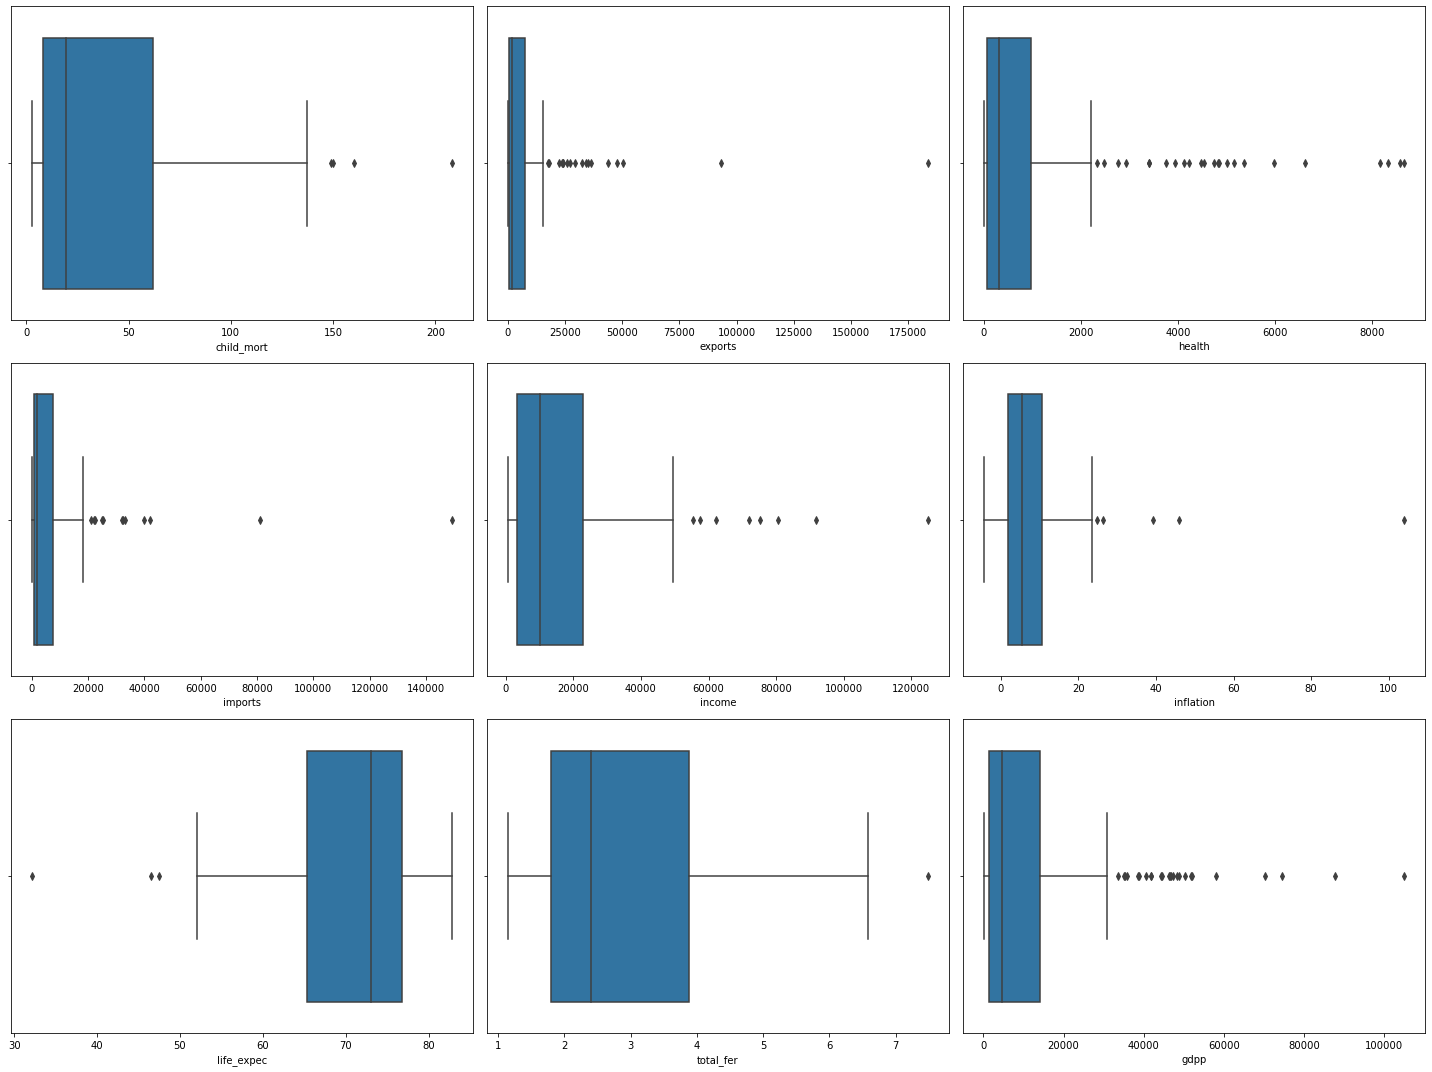

In [11]:
#plotting the distribution of all varibales
plt.figure(figsize=(20, 15))
plt.subplot(3, 3, 1)
sns.boxplot(df.child_mort)
plt.subplot(3, 3, 2)
sns.boxplot(df.exports)
plt.subplot(3, 3, 3)
sns.boxplot(df.health)
plt.subplot(3, 3, 4)
sns.boxplot(df.imports)
plt.subplot(3, 3, 5)
sns.boxplot(df.income)
plt.subplot(3, 3, 6)
sns.boxplot(df.inflation)
plt.subplot(3, 3, 7)
sns.boxplot(df.life_expec)
plt.subplot(3, 3, 8)
sns.boxplot(df.total_fer)
plt.subplot(3, 3, 9)
sns.boxplot(df.gdpp)
plt.tight_layout()
plt.show()

<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> There are outliers in every variable. But if we think about the final objective, which is to find the countries which are in dire need of funds, these "outliers" might actually be the countries which need help. So we will select only a few variables like the below which can be capped at 99 percentile to remove the affluent countries that might not need aid:
   
    1. High gdpp
    2. High income
    3. High imports
    4. High exports
    
 <p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> Let's cap some of the higher end outliers for the above set of variables</b>

In [12]:
#Checking which country has higher than 99 quantile GDPP so that we can make sure it gets changed after capping
df[df["gdpp"]>df["gdpp"].quantile(0.99)]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
91,Luxembourg,2.8,183750.0,8158.50,149100.0,91700,3.62,81.3,1.63,105000
114,Norway,3.2,34856.6,8323.44,25023.0,62300,5.95,81.0,1.95,87800


In [13]:
cap = ["gdpp","income","imports","exports"]

for i in cap:
    df[i] = df[i].apply(lambda x: df[i].quantile(0.99) if x > df[i].quantile(0.99) else x)


In [14]:
#Checking if capped
df[df["country"]=='Norway']

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
114,Norway,3.2,34856.6,8323.44,25023.0,62300.0,5.95,81.0,1.95,79088.0


#### Data is capped at 99 quantile for higher ranged values. Let's move to analyzing the data

## Univariate Analysis and visualization of variables

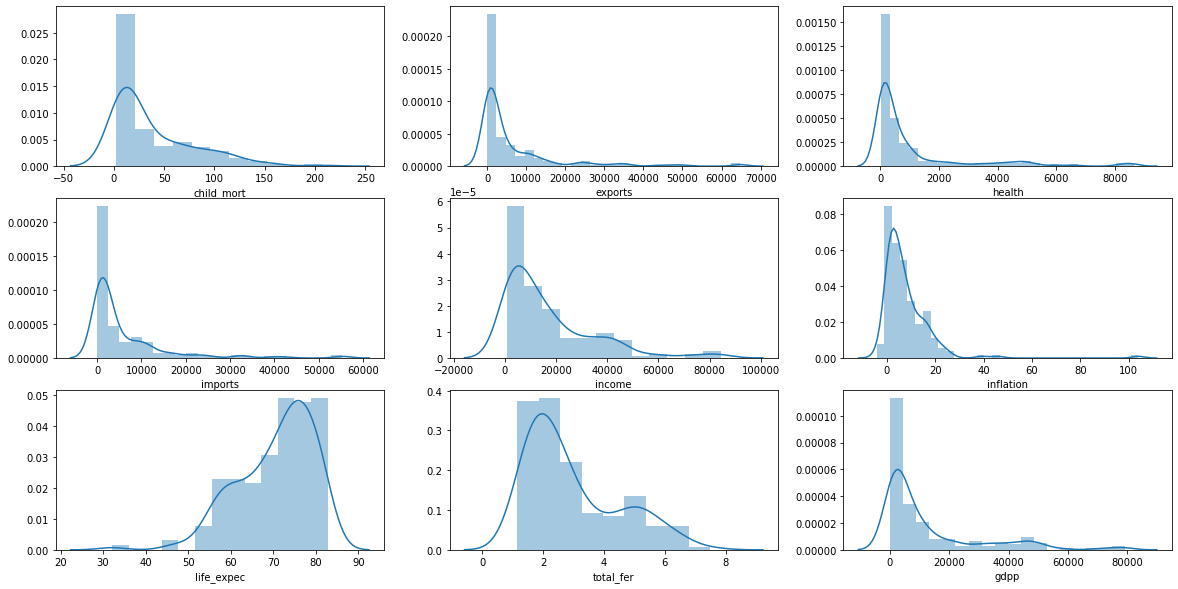

In [15]:
#Let's analyze the distribution of the variables as well
col = df.columns.values
col = np.delete(col,0)
x=1
plt.figure(figsize=[20,10])
for i in col:
    plt.subplot(3,3,x)
    sns.distplot(df[i])
    x=x+1

<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> We notice that the variables are distributed quite differently and that the scales are also very varied. This makes us understand that we need to scale the variable before starting out the clustering.</b>

## Bivariate Analysis

<Figure size 1296x720 with 0 Axes>

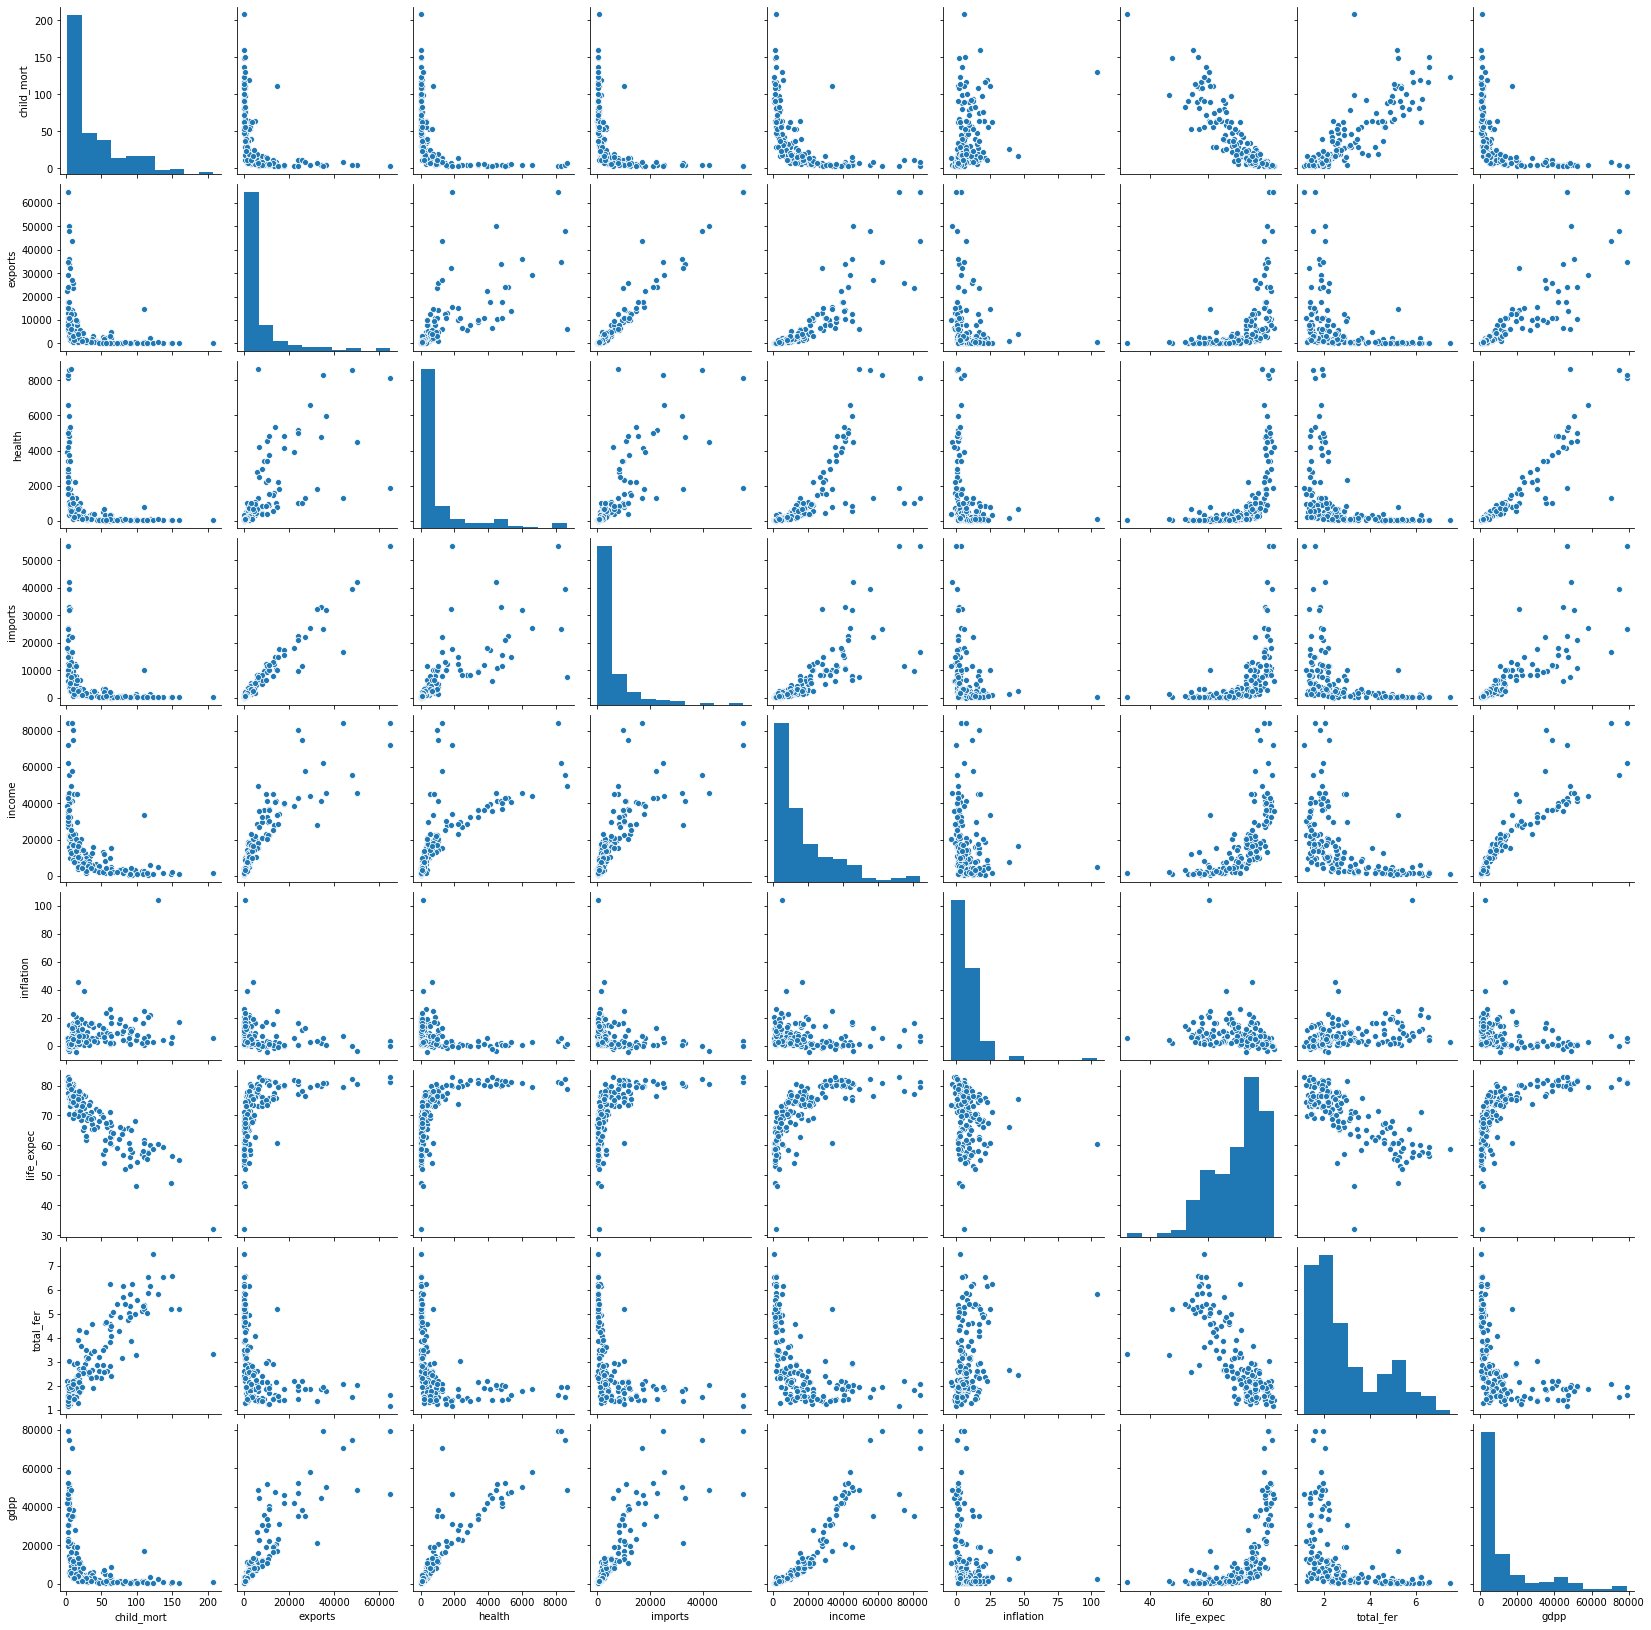

In [16]:
#Let's see how these variables stock up against each other

plt.figure(figsize=[18,10])
sns.pairplot(df)
plt.show()

<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> We notice that there are a few variables which seem to be highly correlated to one another like <i> "life_expec" </i> and  <i> "child_mort" </i> - which makes sense as with the increase of child mortality the life expectency will decrease.

## Scaling the variables

In [17]:
#let's use StandardScaler
scaler =  StandardScaler()

#scale columns
df_scaled = scaler.fit_transform(df[['child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp']])

In [18]:
df_scaled.shape

(167, 9)

In [19]:
#Converting the array to dataframe for analysis
df_scaled = pd.DataFrame(df_scaled, columns= col)
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.569622,-0.565040,-0.598741,-0.851668,0.157336,-1.619092,1.902882,-0.702259
1,-0.538949,-0.473858,-0.439218,-0.413584,-0.386946,-0.312347,0.647866,-0.859973,-0.498726
2,-0.272833,-0.424000,-0.484826,-0.476100,-0.221053,0.789274,0.670423,-0.038404,-0.477434
3,2.007808,-0.381249,-0.532363,-0.463973,-0.612045,1.387054,-1.179234,2.128151,-0.530950
4,-0.695634,-0.086742,-0.178771,0.139728,0.125254,-0.601749,0.704258,-0.541946,-0.032042


<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> Now we have the scaled dataset that we can start our clustering activity on.

## Hopkin's statistic to identify the tendency to cluster

In [20]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [21]:
#Hopkins Statistic
hopkins(df_scaled)

0.9021526601600841

<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> A Hopkin's statistic score of over 0.7 is considered good for clustering. Here, a score of <b> >0.7 suggests the data has a high tendency to cluster.

## Clustering

### 1. K- Means

### Finding optimal number of clusters

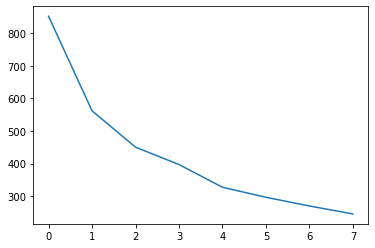

In [22]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=500)
    kmeans.fit(df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [23]:
#using silhouette score

from sklearn.metrics import silhouette_score
clusters = [2,3,4,5,6,7,8,9]

for i in clusters:
    kmeans = KMeans(n_clusters=i, max_iter=500, random_state = 100)
    kmeans.fit(df_scaled)
    print("For cluster size ={0}, the silhouette score = {1}".format(i, silhouette_score(df_scaled, kmeans.labels_)))

For cluster size =2, the silhouette score = 0.47836991760560543
For cluster size =3, the silhouette score = 0.42240786017073967
For cluster size =4, the silhouette score = 0.40813980185795484
For cluster size =5, the silhouette score = 0.4144846208134281
For cluster size =6, the silhouette score = 0.3155680667164774
For cluster size =7, the silhouette score = 0.32301541266125583
For cluster size =8, the silhouette score = 0.29594193071273195
For cluster size =9, the silhouette score = 0.29392119301025216


<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> From the above, it looks like a cluster of size <b>3 or 4 is a good cluster size for our data. </b> Let's do the analysis on these 2 cluster sizes.

#### Cluster size = 3

In [24]:
kmeans =  KMeans(n_clusters=3, max_iter=500, random_state = 100)
kmeans.fit(df_scaled)
clusters = kmeans.labels_

In [25]:
#assigning the clusters
df_2 = df.copy()
df_2["cluster_no_3"] = clusters
df_2.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2


#### Cluster size = 4

In [26]:
kmeans =  KMeans(n_clusters=4, max_iter=500, random_state = 100)
kmeans.fit(df_scaled)
clusters = kmeans.labels_

In [27]:
#assigning clusters
df_2["cluster_no_4"] = clusters
df_2.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3,cluster_no_4
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,2,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,2,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2,2


<p style= "background:lightblue"> <font color ="darkblue", size = 3pt> <b> Let us now check each cluster size and see which one makes business sense

#### For cluster size = 3

In [28]:
#checking no. of countries in the cluster
df_2["cluster_no_3"].value_counts()

2    92
0    48
1    27
Name: cluster_no_3, dtype: int64

### Visualization

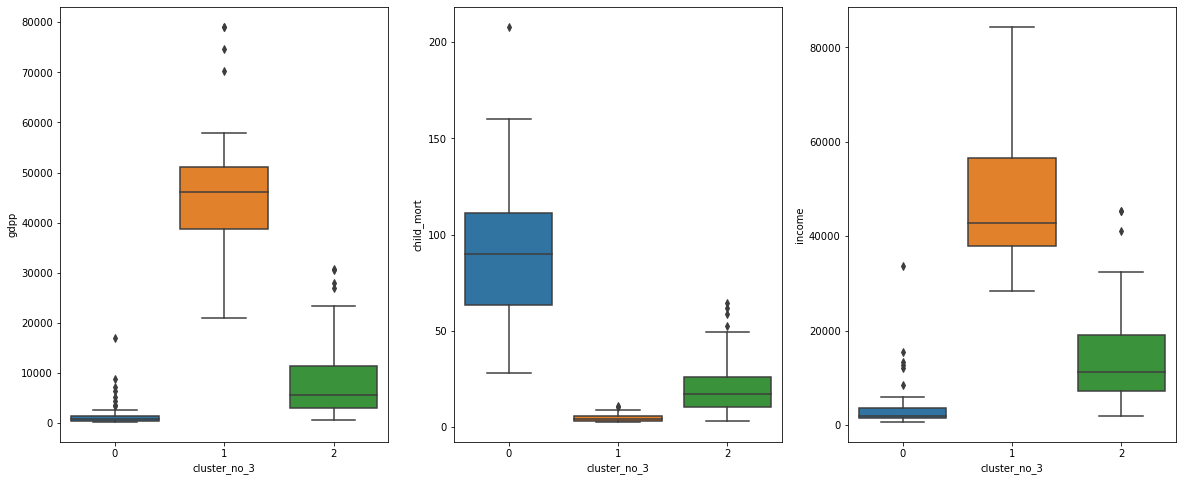

In [29]:
#Let's see how gdpp, child_mort and income plot are distributed for cluster size = 3

#boxplots
plt.figure(figsize=[20,8])
plt.subplot(1,3,1)
sns.boxplot(data=df_2, x= "cluster_no_3", y = "gdpp")
plt.subplot(1,3,2)
sns.boxplot(data=df_2, x= "cluster_no_3", y = "child_mort")
plt.subplot(1,3,3)
sns.boxplot(data=df_2, x= "cluster_no_3", y = "income")
plt.show()

<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> From the above, we notice that the:
    
<span style = "background:pink"><b> 1. gdpp </b> is highest for cluster id = 1; and lowest is for cluster id = 0</span>  
<span style = "background:pink"><b> 2. child_mort </b> is lowest for cluster id = 1 and is the highest for cluster id = 0</span>
    
<span style = "background:pink"><b> 3. income </b> is highest for cluster id = 1 and is the lowest for cluster id = 0</span>

In [30]:
#checking the mean value for the cluster:
df_2.groupby(["cluster_no_3"]).mean().sort_values(by = ["gdpp","child_mort","income"])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_4
cluster_no_3,,,,,,,,,,
0,91.610417,879.063521,114.821765,827.028771,3897.354167,11.911146,59.239583,4.992083,1909.208333,1.00000
2,20.177174,3650.066288,573.165330,3759.545881,14169.456522,6.995435,73.552174,2.225652,8226.869565,1.73913
1,5.092593,26440.026667,4378.955185,22045.851111,49057.333333,3.120407,80.462963,1.775185,47476.888889,1.00000


<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> From the above means and boxplot, it looks like for a cluster count of <b>3</b>: </p>
    
<span style = "background:pink"><b> 1. CLUSTER ID = 1   => Countries with high gdpp, low child mortality and high income
    
<span style = "background:pink"><b> 2. CLUSTER ID = 0   => Countries with low gdpp, very high child mortality and very low income
    
<span style = "background:pink"><b> 3. CLUSTER ID = 2   => Countries with average gdpp, high child mortality and average income

In [31]:
#Let's see the countries in these clusters:
print("Cluster Id = 1 >>\n")
df_2[df_2["cluster_no_3"]==1].head(10)

Cluster Id = 1 >>



,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3,cluster_no_4
7,Australia,4.8,10276.2,4530.87,10847.1,41400.0,1.160,82.0,1.93,51900.0,1,0
8,Austria,4.3,24059.7,5159.00,22418.2,43200.0,0.873,80.5,1.44,46900.0,1,0
15,Belgium,4.5,33921.6,4750.80,33166.8,41100.0,1.880,80.0,1.86,44400.0,1,3
23,Brunei,10.5,23792.2,1002.52,9884.0,80600.0,16.700,77.1,1.84,35300.0,1,0
29,Canada,5.6,13793.4,5356.20,14694.0,40700.0,2.870,81.3,1.63,47400.0,1,0
42,Cyprus,3.6,15461.6,1838.76,17710.0,33900.0,2.010,79.9,1.42,30800.0,1,0
44,Denmark,4.1,29290.0,6612.00,25288.0,44000.0,3.220,79.5,1.87,58000.0,1,3
53,Finland,3.0,17879.4,4134.90,17278.8,39800.0,0.351,80.0,1.87,46200.0,1,0
54,France,4.2,10880.8,4831.40,11408.6,36900.0,1.050,81.4,2.03,40600.0,1,0
58,Germany,4.2,17681.4,4848.80,15507.8,40400.0,0.758,80.1,1.39,41800.0,1,0


In [32]:
print("Cluster Id = 0 >>\n")
df_2[df_2["cluster_no_3"]==0].head(10)

Cluster Id = 0 >>



,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3,cluster_no_4
0,Afghanistan,90.2,55.3000,41.9174,248.297,1610.0,9.440,56.2,5.82,553.0,0,1
3,Angola,119.0,2199.1900,100.6050,1514.370,5900.0,22.400,60.1,6.16,3530.0,0,1
17,Benin,111.0,180.4040,31.0780,281.976,1820.0,0.885,61.8,5.36,758.0,0,1
21,Botswana,52.5,2768.6000,527.0500,3257.550,13300.0,8.920,57.1,2.88,6350.0,0,1
25,Burkina Faso,116.0,110.4000,38.7550,170.200,1430.0,6.810,57.9,5.87,575.0,0,1
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.300,57.7,6.26,231.0,0,1
28,Cameroon,108.0,290.8200,67.2030,353.700,2660.0,1.910,57.3,5.11,1310.0,0,1
31,Central African Republic,149.0,52.6280,17.7508,118.190,888.0,2.010,47.5,5.21,446.0,0,1
32,Chad,150.0,330.0960,40.6341,390.195,1930.0,6.390,56.5,6.59,897.0,0,1
36,Comoros,88.2,126.8850,34.6819,397.573,1410.0,3.870,65.9,4.75,769.0,0,1


In [33]:
print("Cluster Id = 2 >>\n")
df_2[df_2["cluster_no_3"]==2].head(10)

Cluster Id = 2 >>



,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3,cluster_no_4
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.490,76.3,1.65,4090.0,2,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.100,76.5,2.89,4460.0,2,2
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.440,76.8,2.13,12200.0,2,2
5,Argentina,14.5,1946.70,834.3000,1648.000,18700.0,20.900,75.8,2.37,10300.0,2,2
6,Armenia,18.1,669.76,141.6800,1458.660,6700.0,7.770,73.3,1.69,3220.0,2,2
9,Azerbaijan,39.2,3171.12,343.3920,1208.880,16000.0,13.800,69.1,1.92,5840.0,2,2
10,Bahamas,13.8,9800.00,2209.2000,12236.000,22900.0,-0.393,73.8,1.86,28000.0,2,0
11,Bahrain,8.6,14386.50,1028.7900,10536.300,41100.0,7.440,76.0,2.16,20700.0,2,0
12,Bangladesh,49.4,121.28,26.6816,165.244,2440.0,7.140,70.4,2.33,758.0,2,2
13,Barbados,14.2,6320.00,1275.2000,7792.000,15300.0,0.321,76.7,1.78,16000.0,2,2


#### For cluster size = 4

In [34]:
#checking no. of countries in the cluster
df_2["cluster_no_4"].value_counts()

2    80
1    48
0    30
3     9
Name: cluster_no_4, dtype: int64

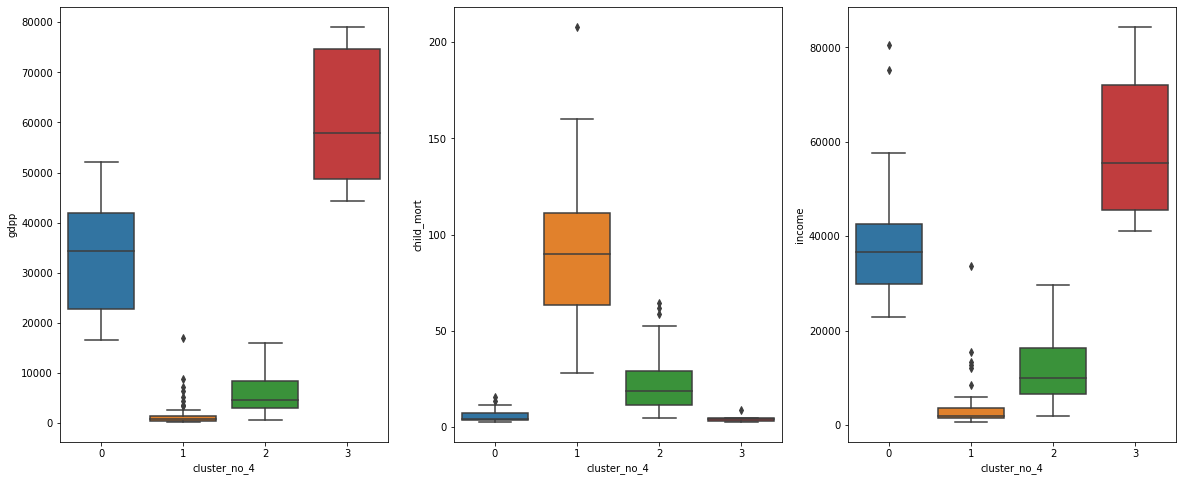

In [35]:
#Let's see how gdpp, child_mort and income plot are distributed for cluster size = 4

#boxplots
plt.figure(figsize=[20,8])
plt.subplot(1,3,1)
sns.boxplot(data=df_2, x= "cluster_no_4", y = "gdpp")
plt.subplot(1,3,2)
sns.boxplot(data=df_2, x= "cluster_no_4", y = "child_mort")
plt.subplot(1,3,3)
sns.boxplot(data=df_2, x= "cluster_no_4", y = "income")
plt.show()

<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> From the above, we notice that the:
    
<span style = "background:pink"><b> 1. gdpp </b> is highest for cluster id = 3 and lowest is for cluster id = 1.</span>  
<span style = "background:pink"><b> 2. child_mort </b> is lowest for cluster id = 0 and 3 and is the highest for cluster id = 1</span>
    
<span style = "background:pink"><b> 3. income </b> is highest for cluster id = 3 and is the lowest for cluster id = 1</span>

In [36]:
#checking the mean value for the cluster:
df_2.groupby(["cluster_no_4"]).mean().sort_values(by = ["gdpp","child_mort","income"])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
cluster_no_4,,,,,,,,,,
1,91.610417,879.063521,114.821765,827.028771,3897.354167,11.911146,59.239583,4.992083,1909.208333,0.0
2,22.157500,2580.729982,385.856630,2793.990264,11478.625000,7.490737,72.871250,2.273375,5962.150000,2.0
0,6.053333,14588.460000,3003.057000,13092.230000,39163.333333,3.634100,79.410000,1.831000,33690.000000,1.4
3,4.400000,45063.846667,5555.862222,36092.231111,59438.666667,2.172111,80.811111,1.765556,61230.666667,1.0


<p style= "background:skyblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> From the above means and boxplot, it looks like for a cluster count of <b>4</b>: </p>
    
<span style = "background:pink"><b> 1. CLUSTER ID = 0 and 3 seem to display very similar characteristics. For example, The child_mort for both are very close (6.05 vs 4.4) as well as gdpp and income. 
    
<span style = "background:pink"><b> 2. CLUSTER ID = 2  </b> => Countries with low gdpp, high child mortality and low income
    
<span style = "background:pink"><b> 3. CLUSTER ID = 1  </b> => Countries with very low gdpp, very high child mortality and very low income
    


## Visualizing

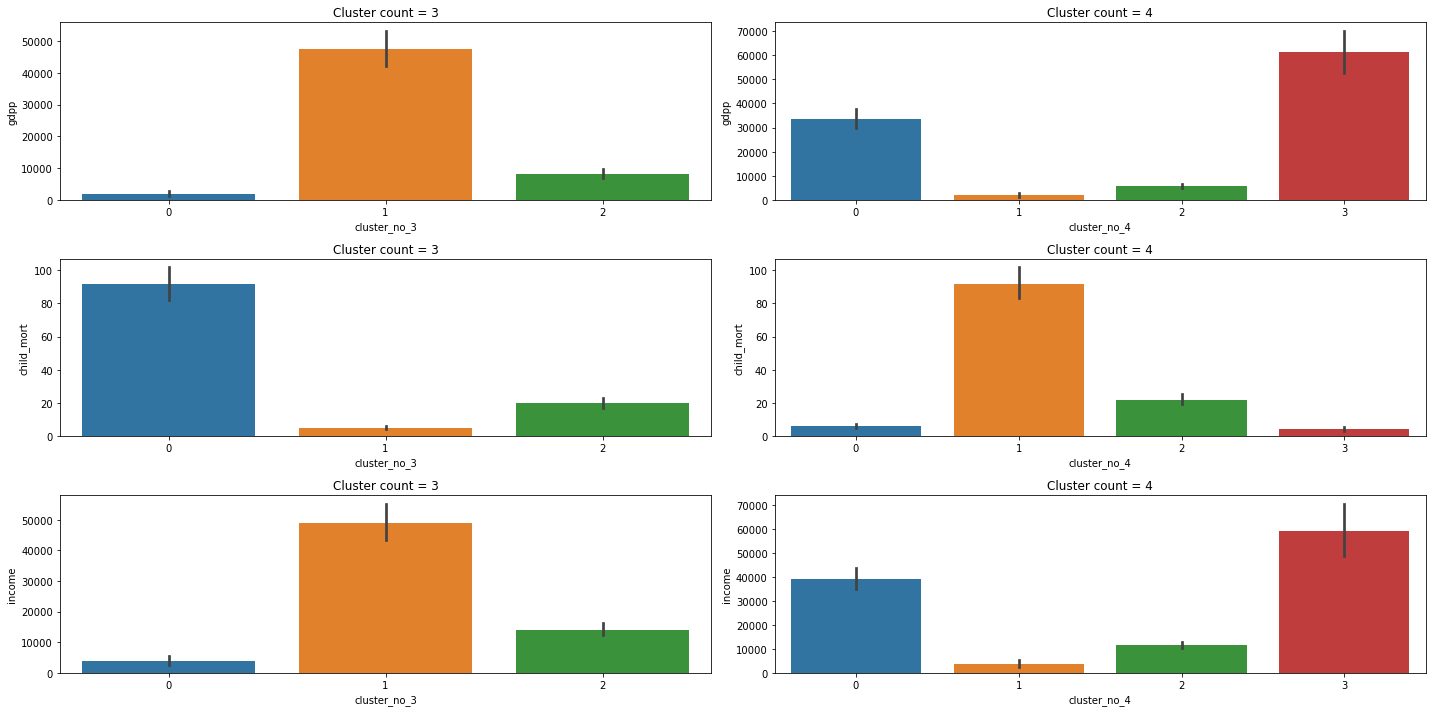

In [37]:
#Making a bar plot
plt.figure(figsize=(20,10))
plt.subplot(3,2,1)
plt.title("Cluster count = 3")
sns.barplot(data=df_2, x="cluster_no_3", y="gdpp")
plt.subplot(3,2,2)
plt.title("Cluster count = 4")
sns.barplot(data=df_2, x="cluster_no_4", y="gdpp")
plt.subplot(3,2,3)
plt.title("Cluster count = 3")
sns.barplot(data=df_2, x="cluster_no_3", y="child_mort")
plt.subplot(3,2,4)
plt.title("Cluster count = 4")
sns.barplot(data=df_2, x="cluster_no_4", y="child_mort")
plt.subplot(3,2,5)
plt.title("Cluster count = 3")
sns.barplot(data=df_2, x="cluster_no_3", y="income")
plt.subplot(3,2,6)
plt.title("Cluster count = 4")
sns.barplot(data=df_2, x="cluster_no_4", y="income")
plt.tight_layout()
plt.show()

<span style = "background:pink"><font color="black"><b> Hence, we note that by KMeans algorithm, it looks like cluster size = 3 is giving the most stable cluster of countries based on our business goal to identify under developed countries. </b>

***

### 2. Hierarchical Clustering

##### let's cluster our data using Hierarchical clustering algorithm and use both single and complete linkage and determine the best cluster size

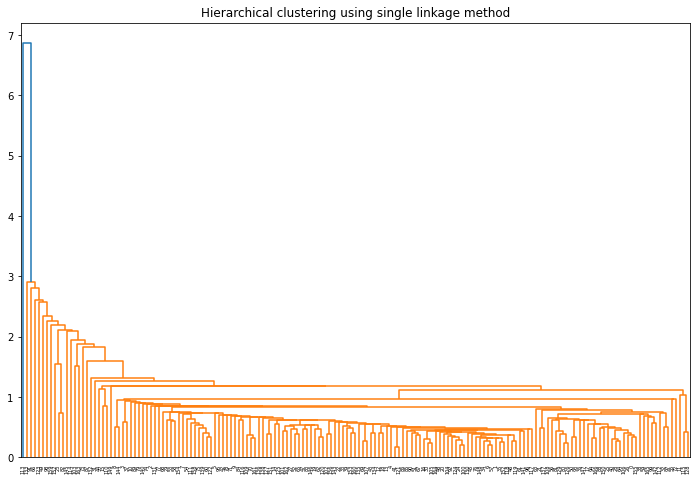

In [38]:
#Single linkage  = distance between 2 clusters is defined as the shortest distance between any 2 point in the clusters

plt.figure(figsize=(12,8))
hierarchy = linkage(df_scaled, method="single", metric ="euclidean")
dendrogram(hierarchy)
plt.title("Hierarchical clustering using single linkage method")
plt.show()

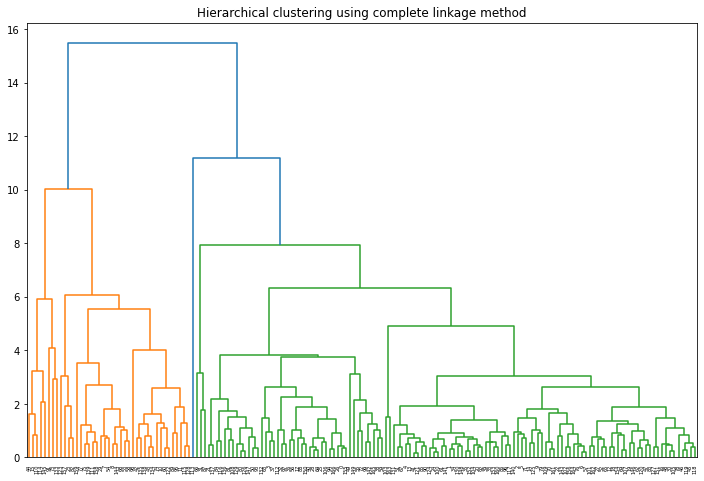

In [39]:
#Complete linkage  = distance between 2 clusters is defined as the maximum distance between any 2 point in the clusters

plt.figure(figsize=(12,8))
hierarchy = linkage(df_scaled, method="complete", metric ="euclidean")
dendrogram(hierarchy)
plt.title("Hierarchical clustering using complete linkage method")
plt.show()

<p style= "background:pink"> &#9654; <font color ="darkblue"> <b> We clearly see that the Complete linkage method gives better cluster formation. Hence we will use this method and cut the clusters at 3 and 4 one by one and analyze the clusters to find the optimal clusters.

#### Cluster size = 3

In [40]:
clusters_3 = cut_tree(hierarchy, n_clusters=3).reshape(-1,)

In [41]:
clusters_3

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [42]:
#adding these to the dataset

df_h1 =  df.copy() #makign a copy of original dataset

#assigning clusters
df_h1["cluster_no_3"] =  clusters_3
df_h1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0


In [43]:
#Checking the split
df_h1["cluster_no_3"].value_counts()

0    125
1     41
2      1
Name: cluster_no_3, dtype: int64

### Visualization

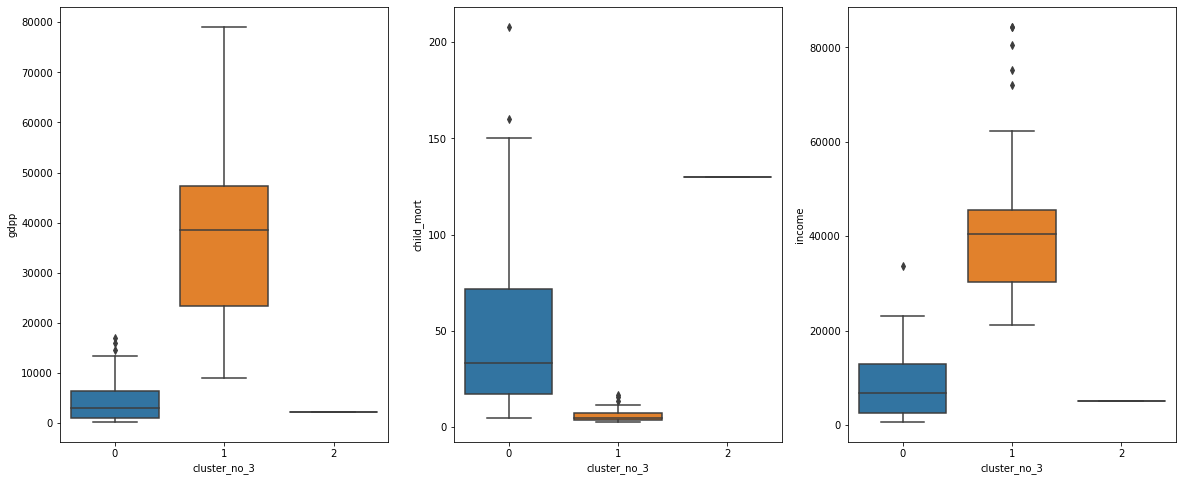

In [44]:
#Let's plot a boxplot and see the important variables

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.boxplot(data=df_h1, y="gdpp", x="cluster_no_3")
plt.subplot(1,3,2)
sns.boxplot(data=df_h1, y="child_mort", x="cluster_no_3")
plt.subplot(1,3,3)
sns.boxplot(data=df_h1, y="income", x="cluster_no_3")
plt.show()

<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> From the above, we notice that the:
    
<span style = "background:pink"><b> 1. gdpp </b> is highest for cluster id = 1 and lowest is for cluster id = 2</span>  
<span style = "background:pink"><b> 2. child_mort </b> is lowest for cluster id = 1 and is the highest for cluster id = 2</span>
    
<span style = "background:pink"><b> 3. income </b> is highest for cluster id = 1 and is the lowest for cluster id = 2</span>

In [45]:
#checking the mean value for the cluster:
df_h1.groupby(["cluster_no_3"]).mean().sort_values(by = ["gdpp","child_mort","income"])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_no_3,,,,,,,,,
2,130.000000,589.490000,118.131000,405.420000,5150.000000,104.000000,60.500000,5.840000,2330.000000
0,48.123200,1857.956220,283.153529,2010.219057,8396.104000,8.364192,67.696800,3.288720,4360.912000
1,5.992683,20952.386585,3438.100561,17783.677561,42940.195122,3.659561,79.517073,1.838537,38608.439024


<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> From the above means and boxplot, it looks like for a cluster count of <b>3</b>, it is very evident that: </p>
    
<span style = "background:pink"><b> 1. CLUSTER ID = 1   = Developed countries
    
<span style = "background:pink"><b> 2. CLUSTER ID = 2   = Under-Developed countries
    
<span style = "background:pink"><b> 3. CLUSTER ID = 0   = Developing countries

In [46]:
#Let's have a look at the countries defined under different brackets as per above:
#Developed countries
print("Cluster Id = 1 >> Developed Countries\n")
df_h1[df_h1["cluster_no_3"]==1].head(10)

Cluster Id = 1 >> Developed Countries



,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
7,Australia,4.8,10276.2,4530.87,10847.1,41400.0,1.160,82.0,1.93,51900.0,1
8,Austria,4.3,24059.7,5159.00,22418.2,43200.0,0.873,80.5,1.44,46900.0,1
10,Bahamas,13.8,9800.0,2209.20,12236.0,22900.0,-0.393,73.8,1.86,28000.0,1
11,Bahrain,8.6,14386.5,1028.79,10536.3,41100.0,7.440,76.0,2.16,20700.0,1
15,Belgium,4.5,33921.6,4750.80,33166.8,41100.0,1.880,80.0,1.86,44400.0,1
23,Brunei,10.5,23792.2,1002.52,9884.0,80600.0,16.700,77.1,1.84,35300.0,1
29,Canada,5.6,13793.4,5356.20,14694.0,40700.0,2.870,81.3,1.63,47400.0,1
42,Cyprus,3.6,15461.6,1838.76,17710.0,33900.0,2.010,79.9,1.42,30800.0,1
43,Czech Republic,3.4,13068.0,1560.24,12454.2,28300.0,-1.430,77.5,1.51,19800.0,1
44,Denmark,4.1,29290.0,6612.00,25288.0,44000.0,3.220,79.5,1.87,58000.0,1


In [47]:
#Under-Developed countries
print("Cluster Id = 2 >> Under-Developed Countries\n")
df_h1[df_h1["cluster_no_3"]==2].head(10)

Cluster Id = 2 >> Under-Developed Countries



,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
113,Nigeria,130.0,589.49,118.131,405.42,5150.0,104.0,60.5,5.84,2330.0,2


In [48]:
#Developing countries
print("Cluster Id = 0 >> Developing Countries\n")
df_h1[df_h1["cluster_no_3"]==0].head(10)

Cluster Id = 0 >> Developing Countries



,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.440,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.490,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.100,76.5,2.89,4460.0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.400,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.440,76.8,2.13,12200.0,0
5,Argentina,14.5,1946.70,834.3000,1648.000,18700.0,20.900,75.8,2.37,10300.0,0
6,Armenia,18.1,669.76,141.6800,1458.660,6700.0,7.770,73.3,1.69,3220.0,0
9,Azerbaijan,39.2,3171.12,343.3920,1208.880,16000.0,13.800,69.1,1.92,5840.0,0
12,Bangladesh,49.4,121.28,26.6816,165.244,2440.0,7.140,70.4,2.33,758.0,0
13,Barbados,14.2,6320.00,1275.2000,7792.000,15300.0,0.321,76.7,1.78,16000.0,0


#### Cluster size = 4

In [49]:
clusters_4 = cut_tree(hierarchy, n_clusters=4).reshape(-1,)

In [50]:
clusters_4

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 3, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [51]:
#adding these to the dataset

#assigning clusters
df_h1["cluster_no_4"] =  clusters_4
df_h1.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3,cluster_no_4
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0,0


In [52]:
#Checking the split
df_h1["cluster_no_4"].value_counts()

0    125
1     33
2      8
3      1
Name: cluster_no_4, dtype: int64

### Visualization

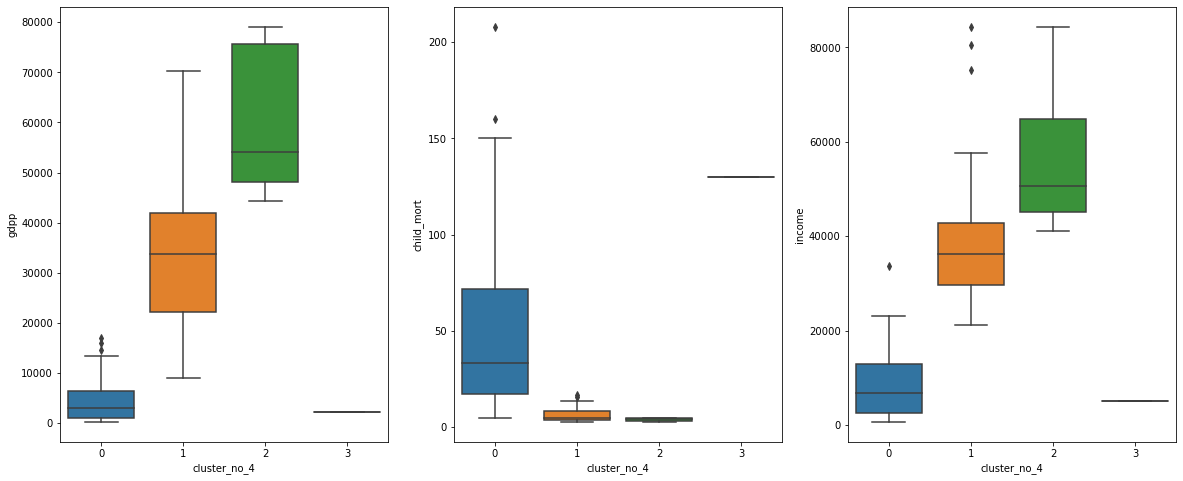

In [53]:
#Let's plot a boxplot and see the important variables

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.boxplot(data=df_h1, y="gdpp", x="cluster_no_4")
plt.subplot(1,3,2)
sns.boxplot(data=df_h1, y="child_mort", x="cluster_no_4")
plt.subplot(1,3,3)
sns.boxplot(data=df_h1, y="income", x="cluster_no_4")
plt.show()

<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> From the above, we notice that the:
    
<span style = "background:pink"><b> 1. gdpp </b> is highest for cluster id = 2 and lowest is for cluster id = 0 and 3</span>  
<span style = "background:pink"><b> 2. child_mort </b> is lowest for cluster id = 2 and is the highest for cluster id = 0 and 3</span>
    
<span style = "background:pink"><b> 3. income </b> is highest for cluster id = 2 and is the lowest for cluster id = 3</span>

In [54]:
#checking the mean value for the cluster:
df_h1.groupby(["cluster_no_4"]).mean().sort_values(by = ["gdpp","child_mort","income"])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
cluster_no_4,,,,,,,,,,
3,130.000000,589.490000,118.131000,405.420000,5150.000000,104.000000,60.500000,5.840000,2330.000000,2
0,48.123200,1857.956220,283.153529,2010.219057,8396.104000,8.364192,67.696800,3.288720,4360.912000,0
1,6.518182,15068.791818,2794.902818,12758.548485,39696.181818,4.165848,79.163636,1.865455,33399.090909,1
2,3.825000,45222.215000,6091.291250,38512.335000,56321.750000,1.571125,80.975000,1.727500,60097.000000,1


### Inferences from Hierarchical

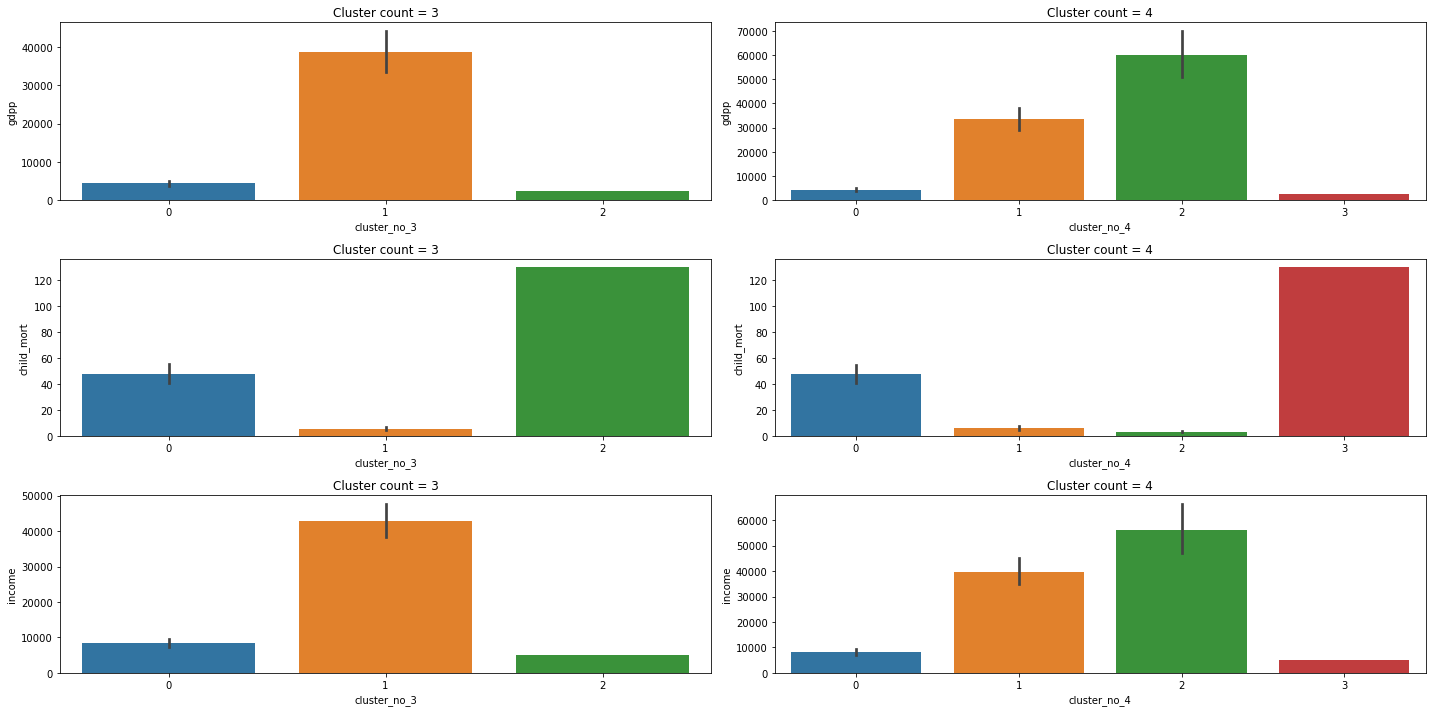

In [55]:
#Making a bar plot
plt.figure(figsize=(20,10))
plt.subplot(3,2,1)
plt.title("Cluster count = 3")
sns.barplot(data=df_h1, x="cluster_no_3", y="gdpp")
plt.subplot(3,2,2)
plt.title("Cluster count = 4")
sns.barplot(data=df_h1, x="cluster_no_4", y="gdpp")
plt.subplot(3,2,3)
plt.title("Cluster count = 3")
sns.barplot(data=df_h1, x="cluster_no_3", y="child_mort")
plt.subplot(3,2,4)
plt.title("Cluster count = 4")
sns.barplot(data=df_h1, x="cluster_no_4", y="child_mort")
plt.subplot(3,2,5)
plt.title("Cluster count = 3")
sns.barplot(data=df_h1, x="cluster_no_3", y="income")
plt.subplot(3,2,6)
plt.title("Cluster count = 4")
sns.barplot(data=df_h1, x="cluster_no_4", y="income")
plt.tight_layout()
plt.show()

<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> From the above clustering using Hierarchical, we see that the data is highly concentrated in few clusters which means we are nto getting a good cluster from hierarchical algorithm. <b> <p style= "background:pink"> We should go ahead with the cluster formation using KMeans and cluster size = 3 as our FINAL MODEL.

## Final Model

<Figure size 720x360 with 0 Axes>

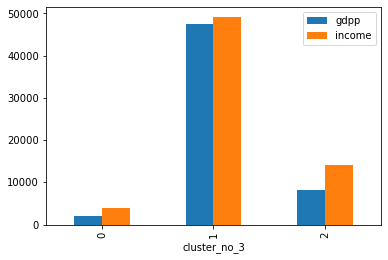

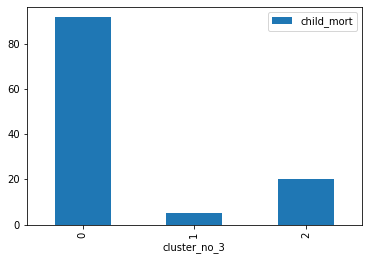

In [56]:
#Visualizing all 3 clusters w.r.t. the socio-economic factors
plt.figure(figsize=(10,5))

Under_dev =df_2[['cluster_no_3','gdpp','income']].copy()
Under_dev=Under_dev.groupby('cluster_no_3').mean()
Under_dev.plot.bar()

Under_dev1=df_2[['cluster_no_3','child_mort']].copy()
Under_dev1=Under_dev1.groupby('cluster_no_3').mean()
Under_dev1.plot.bar()

In [57]:
#checking the mean value for the cluster:
df_final_k_analysis = df_2.groupby(["cluster_no_3"]).mean().sort_values(by = ["gdpp","child_mort","income"], 
                                                                        ascending = [True, False, True])

In [58]:
df_final_k_analysis

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_4
cluster_no_3,,,,,,,,,,
0,91.610417,879.063521,114.821765,827.028771,3897.354167,11.911146,59.239583,4.992083,1909.208333,1.00000
2,20.177174,3650.066288,573.165330,3759.545881,14169.456522,6.995435,73.552174,2.225652,8226.869565,1.73913
1,5.092593,26440.026667,4378.955185,22045.851111,49057.333333,3.120407,80.462963,1.775185,47476.888889,1.00000


#### We clearly see the distinction in the clusters based on their socio-economic factors and can thus label themas follows

In [59]:
#Renaming the clusters
df_final_k_analysis = df_final_k_analysis.rename({
    0: 'Under_Developed Countries',
    1: 'Developed Countries',
    2: 'Developing Countries'}).reset_index()

In [60]:
df_final_k_analysis

,cluster_no_3,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_4
0,Under_Developed Countries,91.610417,879.063521,114.821765,827.028771,3897.354167,11.911146,59.239583,4.992083,1909.208333,1.00000
1,Developing Countries,20.177174,3650.066288,573.165330,3759.545881,14169.456522,6.995435,73.552174,2.225652,8226.869565,1.73913
2,Developed Countries,5.092593,26440.026667,4378.955185,22045.851111,49057.333333,3.120407,80.462963,1.775185,47476.888889,1.00000


In [61]:
#Adding a column of number of countries per cluster
df_final_k_analysis["count"] = df_2[['cluster_no_3','child_mort']].groupby(['cluster_no_3']).count()

In [62]:
df_final_k_analysis

,cluster_no_3,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_4,count
0,Under_Developed Countries,91.610417,879.063521,114.821765,827.028771,3897.354167,11.911146,59.239583,4.992083,1909.208333,1.00000,48
1,Developing Countries,20.177174,3650.066288,573.165330,3759.545881,14169.456522,6.995435,73.552174,2.225652,8226.869565,1.73913,27
2,Developed Countries,5.092593,26440.026667,4378.955185,22045.851111,49057.333333,3.120407,80.462963,1.775185,47476.888889,1.00000,92


<p style= "background:pink"> &#9654; <font color ="darkblue"> <b> FINAL CLUSTER </b> From the above we note that it is the 48 countries clustered in the  "Under_developed" markets that need our attention.
<b> We can check the list of countries now and analyse amongst these the 10 countries which need the aid utmost.

In [63]:
df_final_k_analysis[df_final_k_analysis["cluster_no_3"]=="Under_Developed Countries"]

,cluster_no_3,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_4,count
0,Under_Developed Countries,91.610417,879.063521,114.821765,827.028771,3897.354167,11.911146,59.239583,4.992083,1909.208333,1.0,48


In [64]:
Under_developed = df_2[df_2["cluster_no_3"]==0].copy()
Under_developed.drop("cluster_no_4",axis=1, inplace=True)
Under_developed.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
0,Afghanistan,90.2,55.3000,41.9174,248.297,1610.0,9.440,56.2,5.82,553.0,0
3,Angola,119.0,2199.1900,100.6050,1514.370,5900.0,22.400,60.1,6.16,3530.0,0
17,Benin,111.0,180.4040,31.0780,281.976,1820.0,0.885,61.8,5.36,758.0,0
21,Botswana,52.5,2768.6000,527.0500,3257.550,13300.0,8.920,57.1,2.88,6350.0,0
25,Burkina Faso,116.0,110.4000,38.7550,170.200,1430.0,6.810,57.9,5.87,575.0,0
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.300,57.7,6.26,231.0,0
28,Cameroon,108.0,290.8200,67.2030,353.700,2660.0,1.910,57.3,5.11,1310.0,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888.0,2.010,47.5,5.21,446.0,0
32,Chad,150.0,330.0960,40.6341,390.195,1930.0,6.390,56.5,6.59,897.0,0
36,Comoros,88.2,126.8850,34.6819,397.573,1410.0,3.870,65.9,4.75,769.0,0


In [65]:
#Soritng the data in under developed
Under_developed.sort_values(by=["gdpp","income","child_mort"], ascending =[True, True, False], inplace= True)
Under_developed.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.26,231.0,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.02,327.0,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.54,334.0,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,7.49,348.0,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.20,399.0,0
93,Madagascar,62.2,103.2500,15.5701,177.590,1390.0,8.79,60.8,4.60,413.0,0
106,Mozambique,101.0,131.9850,21.8299,193.578,918.0,7.64,54.5,5.56,419.0,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888.0,2.01,47.5,5.21,446.0,0
94,Malawi,90.5,104.6520,30.2481,160.191,1030.0,12.10,53.1,5.31,459.0,0
50,Eritrea,55.2,23.0878,12.8212,112.306,1420.0,11.60,61.7,4.61,482.0,0


In [66]:
#checking the 50th percentile values (median)
Under_developed.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.0
mean,91.610417,879.063521,114.821765,827.028771,3897.354167,11.911146,59.239583,4.992083,1909.208333,0.0
std,34.319855,2252.474004,165.518331,1540.981910,5590.168621,15.362485,6.384914,1.036192,2925.911009,0.0
min,28.100000,20.605200,12.821200,90.552000,609.000000,0.885000,32.100000,2.590000,231.000000,0.0
25%,63.675000,102.873750,34.005875,193.319500,1390.000000,4.080000,56.725000,4.475000,551.500000,0.0
50%,89.750000,196.260000,51.613500,339.306000,1860.000000,8.855000,59.800000,5.055000,932.000000,0.0
75%,111.000000,552.522500,95.303250,801.000000,3522.500000,16.600000,62.825000,5.597500,1465.000000,0.0
max,208.000000,14671.800000,766.080000,10071.900000,33700.000000,104.000000,71.100000,7.490000,17100.000000,0.0


In [67]:
#let's take the median values of all these socio-economic varibales we are considering, 
#and try to come up with a final list of 10 countries

median_child_mort = np.quantile(Under_developed.child_mort,0.50)
median_income = np.quantile(Under_developed.income,0.50)
median_gdpp = np.quantile(Under_developed.gdpp,0.50)

In [68]:
print("median of child_mort = " , median_child_mort)
print("median of income = " , median_income)
print("median of gdpp = " , median_gdpp)

median of child_mort =  89.75
median of income =  1860.0
median of gdpp =  932.0


##### Let us now filter countries out of the under_deveoped country cluster whose values are lesser than the median values of the socio-economic variables

#### Fetching countries where gdpp is less than the median gdpp

In [69]:
final_list =Under_developed.copy()
final_list=  final_list[final_list["gdpp"]<median_gdpp]
final_list.sort_values(by=["gdpp","income","child_mort"], ascending =[True, True, False], inplace= True)
final_list.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.26,231.0,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.02,327.0,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.54,334.0,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,7.49,348.0,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.20,399.0,0
93,Madagascar,62.2,103.2500,15.5701,177.590,1390.0,8.79,60.8,4.60,413.0,0
106,Mozambique,101.0,131.9850,21.8299,193.578,918.0,7.64,54.5,5.56,419.0,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888.0,2.01,47.5,5.21,446.0,0
94,Malawi,90.5,104.6520,30.2481,160.191,1030.0,12.10,53.1,5.31,459.0,0
50,Eritrea,55.2,23.0878,12.8212,112.306,1420.0,11.60,61.7,4.61,482.0,0


In [70]:
final_list.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.00000,24.0
mean,106.262500,114.765833,34.624258,222.078708,1323.041667,7.695208,57.325000,5.463750,536.87500,0.0
std,35.451962,66.837996,12.269329,90.688808,404.598511,5.312728,6.722852,0.873065,162.31245,0.0
min,55.200000,20.605200,12.821200,90.552000,609.000000,0.885000,32.100000,3.330000,231.00000,0.0
25%,86.400000,67.428000,26.701850,168.091000,1002.000000,3.645000,56.050000,4.982500,417.50000,0.0
50%,97.300000,103.951000,34.970150,193.061000,1390.000000,6.600000,57.950000,5.350000,550.00000,0.0
75%,117.750000,134.635500,41.985600,279.702000,1557.500000,10.850000,60.800000,5.940000,651.50000,0.0
max,208.000000,330.096000,59.115000,428.314000,2090.000000,20.800000,65.900000,7.490000,897.00000,0.0


In [71]:
final_list.shape

(24, 11)

<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> Now we have 24 countries filtered from the original list of 48 under developed countries based on their gdpp being lesser than the median gdpp.
<p style= "background:pink">  Let us now consider the income and filter the countries lesser than median of income

In [72]:
final_list=  final_list[final_list["income"]<median_income]
final_list.sort_values(by=["gdpp","income","child_mort"], ascending =[True, True, False], inplace= True)
final_list.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.26,231.0,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.02,327.0,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.54,334.0,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,7.49,348.0,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.20,399.0,0
93,Madagascar,62.2,103.2500,15.5701,177.590,1390.0,8.79,60.8,4.60,413.0,0
106,Mozambique,101.0,131.9850,21.8299,193.578,918.0,7.64,54.5,5.56,419.0,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888.0,2.01,47.5,5.21,446.0,0
94,Malawi,90.5,104.6520,30.2481,160.191,1030.0,12.10,53.1,5.31,459.0,0
50,Eritrea,55.2,23.0878,12.8212,112.306,1420.0,11.60,61.7,4.61,482.0,0


In [73]:
final_list.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.0
mean,104.352381,101.504095,33.947595,213.662095,1231.571429,7.841667,57.166667,5.360000,503.714286,0.0
std,35.208090,50.119045,12.959473,88.993436,341.585212,5.628270,7.175258,0.861858,140.820859,0.0
min,55.200000,20.605200,12.821200,90.552000,609.000000,0.885000,32.100000,3.330000,231.000000,0.0
25%,88.200000,67.032000,26.419400,165.664000,918.000000,2.970000,55.600000,4.870000,413.000000,0.0
50%,93.600000,101.745000,31.977800,177.590000,1350.000000,6.810000,57.900000,5.310000,488.000000,0.0
75%,116.000000,131.985000,41.917400,279.624000,1430.000000,11.600000,60.800000,5.820000,575.000000,0.0
max,208.000000,196.344000,59.115000,428.314000,1820.000000,20.800000,65.900000,7.490000,769.000000,0.0


In [74]:
final_list.shape

(21, 11)

<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> Now we have 21 countries filtered from the  previous list of 24 under developed countries based on their income being lesser than the median income.
<p style= "background:pink">  Let us now consider the child_mort and filter the countries greater than median of child_mort

In [75]:
final_list=  final_list[final_list["child_mort"]>median_child_mort]
final_list.sort_values(by=["gdpp","income","child_mort"], ascending =[True, True, False], inplace= True)
final_list.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.26,231.0,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.54,334.0,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,7.49,348.0,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.20,399.0,0
106,Mozambique,101.0,131.9850,21.8299,193.578,918.0,7.64,54.5,5.56,419.0,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888.0,2.01,47.5,5.21,446.0,0
94,Malawi,90.5,104.6520,30.2481,160.191,1030.0,12.10,53.1,5.31,459.0,0
150,Togo,90.3,196.1760,37.3320,279.624,1210.0,1.18,58.7,4.87,488.0,0
64,Guinea-Bissau,114.0,81.5030,46.4950,192.544,1390.0,2.97,55.6,5.05,547.0,0
0,Afghanistan,90.2,55.3000,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0


In [76]:
final_list.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
count,14.00000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.0
mean,119.40000,108.060371,33.324143,208.399214,1170.928571,8.388214,54.600000,5.515000,490.500000,0.0
std,33.00035,54.858638,10.825673,87.739975,352.399350,6.477303,7.282223,0.937376,143.745368,0.0
min,90.20000,20.605200,17.750800,90.552000,609.000000,0.885000,32.100000,3.330000,231.000000,0.0
25%,95.45000,69.588000,26.513550,161.559250,895.500000,2.655000,54.625000,5.202500,404.000000,0.0
50%,112.50000,102.969000,31.512200,181.706000,1200.000000,7.225000,56.850000,5.350000,473.500000,0.0
75%,121.25000,135.951750,41.126800,271.792250,1420.000000,12.250000,57.975000,5.857500,569.500000,0.0
max,208.00000,196.344000,52.269000,428.314000,1820.000000,20.800000,61.800000,7.490000,758.000000,0.0


In [77]:
final_list.shape

(14, 11)

<p style= "background:lightblue"> &#9654; <font color ="darkblue"> <b> NOTE: </b> Now we have 14 final list of countries filtered from the previous list of 21 under developed countries based on their child_mort being higher than the median child_mort.
<p style= "background:pink">  Let us take the top 10 countries from this final list as out list of countries to be focussed on.

In [78]:
final_list_under_developed =  final_list.head(10).copy()
final_list_under_developed

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_no_3
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.26,231.0,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.54,334.0,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,7.49,348.0,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.20,399.0,0
106,Mozambique,101.0,131.9850,21.8299,193.578,918.0,7.64,54.5,5.56,419.0,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888.0,2.01,47.5,5.21,446.0,0
94,Malawi,90.5,104.6520,30.2481,160.191,1030.0,12.10,53.1,5.31,459.0,0
150,Togo,90.3,196.1760,37.3320,279.624,1210.0,1.18,58.7,4.87,488.0,0
64,Guinea-Bissau,114.0,81.5030,46.4950,192.544,1390.0,2.97,55.6,5.05,547.0,0
0,Afghanistan,90.2,55.3000,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0


<p style= "background:pink"> &#9654; <font color ="darkblue"> <b> NOTE: </b> Thus, we have below our final list of 10 countries that are in dire need of aid.

In [79]:
final_list_under_developed = final_list_under_developed[["country","gdpp","income", "child_mort" ]]
final_list_under_developed

,country,gdpp,income,child_mort
26,Burundi,231.0,764.0,93.6
37,"Congo, Dem. Rep.",334.0,609.0,116.0
112,Niger,348.0,814.0,123.0
132,Sierra Leone,399.0,1220.0,160.0
106,Mozambique,419.0,918.0,101.0
31,Central African Republic,446.0,888.0,149.0
94,Malawi,459.0,1030.0,90.5
150,Togo,488.0,1210.0,90.3
64,Guinea-Bissau,547.0,1390.0,114.0
0,Afghanistan,553.0,1610.0,90.2


#### Let us visualize the final list of countries and their socio-economic factors

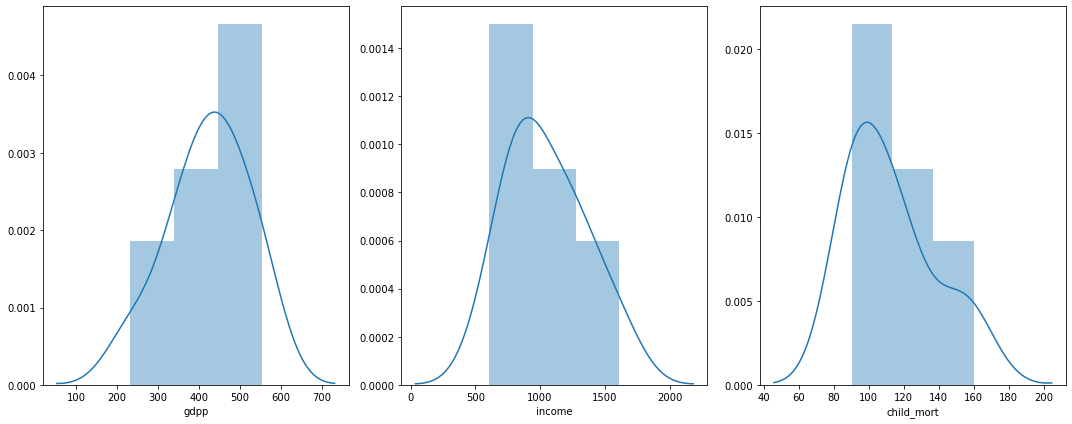

In [80]:
#making a distribution plot
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
sns.distplot(final_list_under_developed["gdpp"])
plt.subplot(1,3,2)
sns.distplot(final_list_under_developed["income"])
plt.subplot(1,3,3)
sns.distplot(final_list_under_developed["child_mort"])
plt.tight_layout()
plt.show()

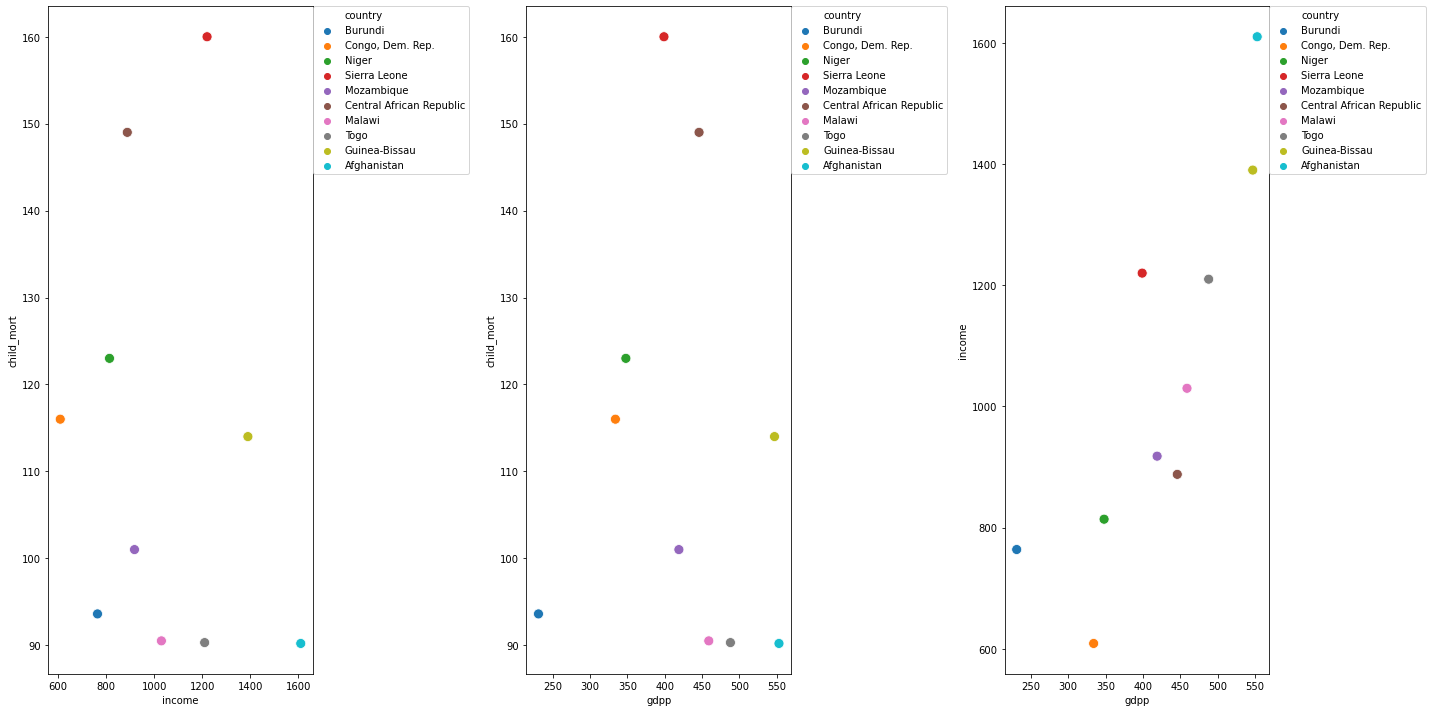

In [81]:
#making a distribution plot
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.scatterplot(data=final_list_under_developed, x= "income", y = "child_mort", hue = "country", s = 100)
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0)
plt.subplot(1,3,2)
sns.scatterplot(data=final_list_under_developed, x= "gdpp", y = "child_mort", hue = "country", s = 100)
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0)
plt.subplot(1,3,3)
sns.scatterplot(data=final_list_under_developed, x= "gdpp", y = "income", hue = "country", s = 100)
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0)
plt.tight_layout()
plt.show()

<p style= "background:pink"> &#9654; <font color ="darkblue"> <b> CONCLUSION:  We did the clustering based on the socio-economic data provided for various countries in order to recommend countries which are in dire need of aid from HELP International. 
Based on our approach, we found the top 10 countries that are in dire need of assistance and can recomment this to the business.

***

## FINAL LIST OF COUNTRIES

In [82]:
final_list_under_developed.describe()

,gdpp,income,child_mort
count,10.00000,10.000000,10.00000
mean,422.40000,1045.300000,112.76000
std,99.62396,309.034356,25.11344
min,231.00000,609.000000,90.20000
25%,360.75000,832.500000,91.27500
50%,432.50000,974.000000,107.50000
75%,480.75000,1217.500000,121.25000
max,553.00000,1610.000000,160.00000


In [83]:
final_list_under_developed

,country,gdpp,income,child_mort
26,Burundi,231.0,764.0,93.6
37,"Congo, Dem. Rep.",334.0,609.0,116.0
112,Niger,348.0,814.0,123.0
132,Sierra Leone,399.0,1220.0,160.0
106,Mozambique,419.0,918.0,101.0
31,Central African Republic,446.0,888.0,149.0
94,Malawi,459.0,1030.0,90.5
150,Togo,488.0,1210.0,90.3
64,Guinea-Bissau,547.0,1390.0,114.0
0,Afghanistan,553.0,1610.0,90.2


***